<a href="https://colab.research.google.com/github/takuma-uchida/google_colab_uchida/blob/main/%E3%80%90HRT%E3%80%91%E9%81%A9%E6%80%A7%E3%83%9E%E3%83%83%E3%83%81%E3%83%B3%E3%82%B0_%E5%80%8B%E4%BA%BA%E5%AF%BE%E6%8E%A1%E7%94%A8%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

## ドライブ認証等

In [ ]:
#ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

#認証
from google.colab import auth
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ライブラリー読込

In [ ]:
# matplotlibの日本語化に使用
!pip install japanize_matplotlib

#基本ライブラリー
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import japanize_matplotlib
import plotly.express as px
import time

#正規化
from sklearn.preprocessing import MinMaxScaler

#クラスター分析
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# マハラノビス距離
from scipy.spatial.distance import mahalanobis

# 多次元尺度構成法(MDS)
from sklearn.manifold import MDS

## このコラボがいるファイルパスまで移動

In [ ]:
#特定のディレクトリに移動
%cd /content/drive/My Drive/mar-データ戦略/事業施策/HRTech/[HRT]適性マッチのマッチングロジック

/content/drive/.shortcut-targets-by-id/1RLRkq0c3TMfT_n4FaUruqWK2YQsqpq_s/mar-データ戦略/事業施策/HRTech/[HRT]適性マッチのマッチングロジック


## BQからデータ読込

In [ ]:
%%bigquery input_rawdata --project hrtech-datainfra-prod
/*
HRT_Nalysys
*/
select
  es.employee_id --pionaly回答者ID
  ,e.corporation_id --pionaly回答者の所属会社ID
  ,esf.factor_type_id --pionalyの各因子の名称
  ,esf.value --pionalyの各因子の因子スコア
  ,es.scoring_date --pionaly回答者の回答日
from
  `hrtech-datainfra-prod.view_worx_personal.employee_score_factors` as esf
left join
  `hrtech-datainfra-prod.view_worx_personal.employee_scores` as es
  on esf.score_id = es.id
left join
  `hrtech-datainfra-prod.view_worx_personal.employee_personals` as ep
  on es.employee_id = ep.id
left join
  `hrtech-datainfra-prod.view_worx_employee.employee` as e
  on ep.id = e.id
where
  es.is_answered = true --未回答者を除く（回答者に絞る）
  and es.type_id = 'pionaly' --pionaly回答者に絞る
order by
  employee_id

Query is running:   0%|          |

Downloading:   0%|          |

## 距離測定に使う因子のみに絞る

In [ ]:
# パーソナリティ_日本語
factor3_type_japanese = ["回復力","活動性","達成欲"]
factor5_type_japanese = ["回復力","活動性","達成欲","安定感","計画性"]
factor16_type_japanese = ["社交性","影響性","好奇心","創造性","謙虚心","援助心","安定感","回復力","計画性","正義感","慎重性","持続性","活動性","達成欲","目的的","競争心"]

In [ ]:
# 「factor_type」の名称を追加
file_path = "factorTypeIdと因子名.csv"
factor_type_id_conversion = pd.read_csv(file_path, encoding='utf-8')

# パーソナリティの「自責性」「批判性」以外_英語
factor_type_english = []
for _,row in factor_type_id_conversion.iterrows():
  for i in factor3_type_japanese:
    if row["factor_type_name"] == i:
      factor_type_english.append(row["factor_type_id"])

# 距離算出に使用する因子のみのデータに絞る
input_rawdata = pd.merge(input_rawdata, factor_type_id_conversion, how ='left', on="factor_type_id")
input_rawdata = input_rawdata[input_rawdata['factor_type_name'].isin(factor3_type_japanese)]
input_data = input_rawdata.drop('factor_type_name', axis=1)
input_data.head(5)

,employee_id,corporation_id,factor_type_id,value,scoring_date
10,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,achievement,3.9569429750859006,2024-10-17 02:15:08
41,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,resilience,5.53271737816049,2024-10-17 02:15:08
58,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,activity,3.612698031993185,2024-10-17 02:15:08
105,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,resilience,3.4790523135439546,2024-05-08 09:23:08
127,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,achievement,3.4778784162671394,2024-05-08 09:23:08


## データ成形

In [ ]:
# 「value」をフロート値に変換
input_data["value"] = input_data["value"].astype(float)

# scoring_date列から「○○○○-○○-○○」を抽出
input_data['scoring_date'] = input_data['scoring_date'].astype(str).str[:10]

# scoring_dateをデータ型に変換
input_data["scoring_date"] = pd.to_datetime(input_data["scoring_date"])

# 各employee_idの最新のscoring_dateを取得
latest_scoring_dates = input_data.groupby('employee_id')['scoring_date'].max()

# 新しいカラム「is_latest」を追加し、初期値を0に設定
input_data['is_latest'] = 0

# 最新のscoring_dateを持つ行に1を設定
for employee_id, latest_date in latest_scoring_dates.items():
    input_data.loc[(input_data['employee_id'] == employee_id) & (input_data['scoring_date'] == latest_date), 'is_latest'] = 1

# is_latestが0のレコードを削除
input_data = input_data[input_data['is_latest'] == 1]

# 列を削除
input_data = input_data.drop(['is_latest', 'scoring_date'], axis=1)

#因子スコアカラムをダミー変数化
factor_df = pd.get_dummies(input_data, columns=['factor_type_id'], prefix='', prefix_sep='', dtype=int)
for col in factor_type_english:
  if col in factor_df.columns:
      factor_df[col] = factor_df[col] * factor_df["value"]

input_data = factor_df.groupby('employee_id', as_index=False).agg(
     {'corporation_id': 'first'}|{col: 'sum' for col in factor_type_english} )

# 「employee_id」のHRテック従業員の名称を追加
file_path = "HRテック従業員_レバ全社員.csv"
employee_name = pd.read_csv(file_path, encoding='utf-8')
# Name1のフルネームを追加
input_data = pd.merge(input_data, employee_name, left_on='employee_id', right_on='employee_id', how='left')

input_data

,employee_id,corporation_id,resilience,activity,achievement,fullname
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,5.532717,3.612698,3.956943,NaN
1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,3.479052,3.774801,3.477878,中野上 龍太郎
2,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,8.300193,9.050000,8.322711,相月 俊紀
3,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,6.113833,5.445990,3.882562,ルパワッタゲ アナン
4,008d1131-c9fc-4177-859c-dedc52575558,None,6.122444,7.315717,6.912303,黒澤 愛夏
...,...,...,...,...,...,...
4340,ffd67bfb-0309-4f64-89a5-38ae6930fb59,56f195ed-73e8-4efe-bdd5-4b26072e6080,3.564276,4.405918,4.636051,NaN
4341,fff0847a-2668-4fa9-9980-bd7172c1a7e1,56f195ed-73e8-4efe-bdd5-4b26072e6080,4.783702,6.885248,3.040741,弘津 未彩
4342,fff22958-1634-4517-b656-40b8095bc8bd,56f195ed-73e8-4efe-bdd5-4b26072e6080,3.832304,5.132339,4.706460,椛沢 はるな
4343,fff7ab5e-fe53-4704-9b9a-34b3e371ad47,56f195ed-73e8-4efe-bdd5-4b26072e6080,6.847039,4.604791,6.793609,小泉 拓巳


In [ ]:
# 田川さんの因子スコアのレコードを追加
tagawa_record = {
    'employee_id': "G00019",
    'corporation_id': "56f195ed-73e8-4efe-bdd5-4b26072e6080",
    'sociability':2.8,
    'influence':8.2,
    'curiosity':7.4,
    'creativity':7.7,
    'humility':1.3,
    'willingness':8.3,
    'stability':8.7,
    'resilience':8.1,
    'planning':3.7,
    'justice':7.4,
    'prudence':3.4,
    'persistence':8.3,
    'activity':8.7,
    'achievement':8.0,
    'purposeful':5.8,
    'competitiveness':6.8,
    'fullname': "田川 勇輝"
}
tagawa_factors = {key: value for key, value in tagawa_record.items() if key in factor_type_english}
tagawa_selected = {key: value for key, value in tagawa_record.items() if key in ['employee_id', 'corporation_id', 'fullname']}
tagawa_combined = {**tagawa_selected, **tagawa_factors}

hukui_record = {
    'employee_id': "20110097",
    'corporation_id': "56f195ed-73e8-4efe-bdd5-4b26072e6080",
    'sociability':5.8,
    'influence':6.9,
    'curiosity':6.0,
    'creativity':6.8,
    'humility':2.8,
    'willingness':6.2,
    'stability':6.9,
    'resilience':6.7,
    'planning':1.3,
    'justice':6.7,
    'prudence':2.7,
    'persistence':6.7,
    'activity':6.4,
    'achievement':5.9,
    'purposeful':6.1,
    'competitiveness':6.0,
    'fullname': "福井 凪桜"
}
hukui_factors = {key: value for key, value in hukui_record.items() if key in factor_type_english}
hukui_selected = {key: value for key, value in hukui_record.items() if key in ['employee_id', 'corporation_id', 'fullname']}
hukui_combined = {**hukui_selected, **hukui_factors}

input_data = pd.concat([input_data, pd.DataFrame([tagawa_combined]), pd.DataFrame([hukui_combined])], ignore_index=True)

In [ ]:
input_data

,employee_id,corporation_id,resilience,activity,achievement,fullname
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,5.532717,3.612698,3.956943,NaN
1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,3.479052,3.774801,3.477878,中野上 龍太郎
2,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,8.300193,9.050000,8.322711,相月 俊紀
3,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,6.113833,5.445990,3.882562,ルパワッタゲ アナン
4,008d1131-c9fc-4177-859c-dedc52575558,None,6.122444,7.315717,6.912303,黒澤 愛夏
...,...,...,...,...,...,...
4342,fff22958-1634-4517-b656-40b8095bc8bd,56f195ed-73e8-4efe-bdd5-4b26072e6080,3.832304,5.132339,4.706460,椛沢 はるな
4343,fff7ab5e-fe53-4704-9b9a-34b3e371ad47,56f195ed-73e8-4efe-bdd5-4b26072e6080,6.847039,4.604791,6.793609,小泉 拓巳
4344,ffff3122-60fd-4795-9f85-0b20d0640222,76230de6-c0ec-42a6-a6c9-9c855f49419f,2.739620,5.730542,5.408054,NaN
4345,G00019,56f195ed-73e8-4efe-bdd5-4b26072e6080,8.100000,8.700000,8.000000,田川 勇輝


## 回答者idと企業idのデータフレームを作成

In [ ]:
# 回答者idと企業IDのデータ
employee_company_data = input_data[["employee_id", "corporation_id"]]
employee_company_data = employee_company_data.drop_duplicates(subset=["employee_id", "corporation_id"])
employee_company_data

,employee_id,corporation_id
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac
1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080
2,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080
3,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080
4,008d1131-c9fc-4177-859c-dedc52575558,None
...,...,...
4342,fff22958-1634-4517-b656-40b8095bc8bd,56f195ed-73e8-4efe-bdd5-4b26072e6080
4343,fff7ab5e-fe53-4704-9b9a-34b3e371ad47,56f195ed-73e8-4efe-bdd5-4b26072e6080
4344,ffff3122-60fd-4795-9f85-0b20d0640222,76230de6-c0ec-42a6-a6c9-9c855f49419f
4345,G00019,56f195ed-73e8-4efe-bdd5-4b26072e6080


## 回答者idと正規化した因子スコアのデータフレームを作成

In [ ]:
# 因子スコアを正規化
scaler = MinMaxScaler()
factor_score = input_data.columns.difference(['employee_id', 'fullname', 'corporation_id'])
factor_score_scaling = input_data.copy()
factor_score_scaling[factor_score] = factor_score_scaling[factor_score]*10
factor_score_scaling = factor_score_scaling.drop('corporation_id', axis=1)
factor_score_scaling.head(5)

,employee_id,resilience,activity,achievement,fullname
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,55.327174,36.126980,39.569430,NaN
1,0033e100-e265-45cb-8c98-2f20d4d54184,34.790523,37.748006,34.778784,中野上 龍太郎
2,004d1690-175d-484f-b35a-46326d8c2bcc,83.001930,90.500002,83.227109,相月 俊紀
3,00857a9d-9622-4c65-983e-ae062d6e2b19,61.138334,54.459899,38.825621,ルパワッタゲ アナン
4,008d1131-c9fc-4177-859c-dedc52575558,61.224437,73.157171,69.123035,黒澤 愛夏


In [ ]:
# # 因子スコアを正規化
# scaler = MinMaxScaler()
# factor_score = input_data.columns.difference(['employee_id', 'fullname', 'corporation_id'])
# factor_score_scaling = input_data.copy()
# factor_score_scaling[factor_score] = scaler.fit_transform(factor_score_scaling[factor_score])*100
# factor_score_scaling = factor_score_scaling.drop('corporation_id', axis=1)
# factor_score_scaling.head(5)

# ユークリッド距離

## 採用モデルを作成

### ユーザーに実数で選択

In [ ]:
# factor_columns = ["achievement", "activity", "competitiveness", "prudence", "purposeful"]
# adopt_model_raw = {}
# selected_conditions = []

# for factor in factor_columns:
#     print(f"{factor}について条件式と関連情報を入力してください。")

#     # 不等式を受け取る
#     inequality_input = input("以上・以下・以上以下・実数のどれですか？")

#     if inequality_input == "以上":
#       condition_input = input("条件式,条件式の値 (例: x > 0.66, 0.66)：").strip()

#       try:
#           # 入力をカンマで分割し、各部分を処理
#           parts = [p.strip() for p in condition_input.split(",")]
#           condition_lambda = eval(f"lambda x: {parts[0]}") # 不等式
#           th1 = float(parts[1]) # 不等式の値
#           th2 = 1
#           cate = 1
#           adopt_model_raw[factor] = [(condition_lambda, th1, th2, cate)]

#       except Exception as e:
#           print(f"無効な入力: {condition_input}")
#           print(f"エラー: {e}")


#     if inequality_input == "以上以下":
#       condition_input = input("条件式,条件式の値, 条件式の値 (例: 0.40 < x < 0.76, 0.40, 0.76)：").strip()

#       try:
#           # 入力をカンマで分割し、各部分を処理
#           parts = [p.strip() for p in condition_input.split(",")]
#           condition_lambda = eval(f"lambda x: {parts[0]}") # 不等式
#           th1 = float(parts[1]) # 不等式の値
#           th2 = float(parts[2]) # 不等式の値
#           cate = 2
#           adopt_model_raw[factor] = [(condition_lambda, th1, th2, cate)]

#       except Exception as e:
#           print(f"無効な入力: {condition_input}")
#           print(f"エラー: {e}")


#     if inequality_input == "以下":
#       condition_input = input("条件式,条件式の値 (例: x < 0.23, 0.23)：").strip()

#       try:
#           # 入力をカンマで分割し、各部分を処理
#           parts = [p.strip() for p in condition_input.split(",")]
#           condition_lambda = eval(f"lambda x: {parts[0]}") # 不等式
#           th1 = float(parts[1]) # 不等式の値
#           th2 = 1
#           cate = 3
#           adopt_model_raw[factor] = [(condition_lambda, th1, th2, cate)]

#       except Exception as e:
#           print(f"無効な入力: {condition_input}")
#           print(f"エラー: {e}")


#     if inequality_input == "実数":
#       condition_input = input("式,式の値 (例: x == 0.45, 0.45)：").strip()

#       try:
#           # 入力をカンマで分割し、各部分を処理
#           parts = [p.strip() for p in condition_input.split(",")]
#           condition_lambda = eval(f"lambda x: {parts[0]}") # 不等式
#           th1 = float(parts[1]) # 不等式の値
#           th2 = 1
#           cate = 4
#           adopt_model_raw[factor] = [(condition_lambda, th1, th2, cate)]

#       except Exception as e:
#           print(f"無効な入力: {condition_input}")
#           print(f"エラー: {e}")

# # 条件の確認
# # print("ユーザーが入力した条件:")
# # for factor, condition in adopt_model_raw.items():
# #     print(f"{factor}: {condition}")
# adopt_model_raw

### ユーザーに段階で選択

In [ ]:
# factor_columns = ["achievement", "activity", "competitiveness", "prudence", "purposeful"]
# adopt_model_raw = {}
# for factor in factor_columns:
#   # 選択肢の表示
#   print(f"{factor}について次の選択肢から複数選んでください（カンマで区切って入力してください）")
#   print("1. 高い")
#   print("2. 普通")
#   print("3. 低い")
#   # ユーザーの入力を取得
#   user_input = input("番号を入力してください（例: 1,2,3）: ")
#   # 条件と対応する閾値の辞書
#   conditions = {
#       "1": (lambda x: x > 0.66, 0.66, 1.00, 1),    # 高い
#       "2": (lambda x: 0.33 <= x <= 0.66, 0.33, 0.66, 2),  # 普通
#       "3": (lambda x: x < 0.33, 0.33, 1.00, 3),     # 低い
#       "1,2":(lambda x: x > 0.33, 0.33, 1.00, 1.2), # 高い・普通
#       "2,3":(lambda x: x < 0.66, 0.66, 1.00, 2.3), # 普通・低い
#   }
#   # 選択に応じた条件を収集
#   selected_conditions = []
#   condition = conditions.get(user_input.strip())
#   print(user_input)
#   print(condition)
#   if condition:  # 辞書に存在するか確認
#       selected_conditions.append(condition)
#   else:
#       print(f"無効な選択肢: {user_input.strip()}")
#   adopt_model_raw[factor] = selected_conditions
# adopt_model_raw

### 採用モデルを設定

In [ ]:
# # condition_lambda = eval(f"lambda x: x > 0.66") # 不等式
# # th1 = 0.66 # 不等式の値
# # th2 = 1
# # 【cate】以上：1、以上以下：2、以下：3、実数：4
# adopt_model_raw = {}
#   adopt_model_raw["achievement"] = [(eval(f"lambda x: x > 0.66"), 0.66, 1, 1)]
#   adopt_model_raw["activity"] = [(eval(f"lambda x: x < 0.50"), 0.50, 1, 3)]
#   adopt_model_raw["competitiveness"] = [(eval(f"lambda x: x < 0.70"), 0.70, 1, 3)]
#   adopt_model_raw["prudence"] = [(eval(f"lambda x: 0.40 < x < 0.76"), 0.40, 0.76, 2)]
#   adopt_model_raw["purposeful"] = [(eval(f"lambda x: x == 0.80"), 0.80, 1, 4)]
# adopt_model_raw

In [ ]:
adopt_model_raw = {}
for i in factor_type_english:
  adopt_model_raw[i] = [(eval(f"lambda x: x > 6.6"), 6.6, 10, 1)]
adopt_model_raw

{'resilience': [(<function __main__.<lambda>(x)>, 6.6, 10, 1)],
 'activity': [(<function __main__.<lambda>(x)>, 6.6, 10, 1)],
 'achievement': [(<function __main__.<lambda>(x)>, 6.6, 10, 1)]}

In [ ]:
# adopt_model_raw["justice"] = [(eval(f"lambda x: x < 3.3"), 3.3, 10, 3)]
# adopt_model_raw["prudence"] = [(eval(f"lambda x: x < 3.3"), 3.3, 10, 3)]
# adopt_model_raw

In [ ]:
# 採用モデルを作成

# 以上以下_上側
adopt_model_upper = []

# 以上以下_上側以外
adopt_model_upper_outside = []

for factor, conditions in adopt_model_raw.items():
  for condition, th1, th2, user_input in conditions:
    if user_input == 2: #「以上以下」の場合
      adopt_model_upper.append(th2) #「以上以下」
    else:
      adopt_model_upper.append(th1) #「以上以下」以外
    adopt_model_upper_outside.append(th1)

print(f"adopt_model_upper：{adopt_model_upper}")
print(f"adopt_model_upper_outside：{adopt_model_upper_outside}")

adopt_model_upper：[6.6, 6.6, 6.6]
adopt_model_upper_outside：[6.6, 6.6, 6.6]


### 個人スコアを修正

In [ ]:
# 個人スコアを修正
input_data_revision = input_data.copy() # 既存のDataFrameをコピー
input_data_revision['inequality_flag'] = 0 # 不等式フラグ列を追加

for index, row in input_data_revision.iterrows():
  for factor in factor_type_english:
    if factor in adopt_model_raw:
      for condition, th1, th2, user_input in adopt_model_raw[factor]:
        if condition(row[factor]): #各因子のスコアが不等式に対しTureのとき
            input_data_revision.loc[index, factor] = th1
        # 「以上以下」かつ値が「以上」より大きい場合、フラグを設定
        if user_input == 2 and row[factor] >= th2:
            input_data_revision.loc[index, 'inequality_flag'] = 1

input_data_revision

,employee_id,corporation_id,resilience,activity,achievement,fullname,inequality_flag
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,5.532717,3.612698,3.956943,NaN,0
1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,3.479052,3.774801,3.477878,中野上 龍太郎,0
2,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,6.600000,6.600000,6.600000,相月 俊紀,0
3,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,6.113833,5.445990,3.882562,ルパワッタゲ アナン,0
4,008d1131-c9fc-4177-859c-dedc52575558,None,6.122444,6.600000,6.600000,黒澤 愛夏,0
...,...,...,...,...,...,...,...
4342,fff22958-1634-4517-b656-40b8095bc8bd,56f195ed-73e8-4efe-bdd5-4b26072e6080,3.832304,5.132339,4.706460,椛沢 はるな,0
4343,fff7ab5e-fe53-4704-9b9a-34b3e371ad47,56f195ed-73e8-4efe-bdd5-4b26072e6080,6.600000,4.604791,6.600000,小泉 拓巳,0
4344,ffff3122-60fd-4795-9f85-0b20d0640222,76230de6-c0ec-42a6-a6c9-9c855f49419f,2.739620,5.730542,5.408054,NaN,0
4345,G00019,56f195ed-73e8-4efe-bdd5-4b26072e6080,6.600000,6.600000,6.600000,田川 勇輝,0


In [ ]:
# input_data_revision = input_data.copy()
# input_data_revision["inequality_flag"] = 0

# # 個人スコアを修正
# for index, row in input_data_revision.iterrows():
#   if 'achievement' in adopt_model_raw:
#       for condition, th1, th2, user_input in adopt_model_raw['achievement']:
#         if condition(row['achievement']):
#             if user_input == 2:  #「以上以下」かどうか
#               input_data_revision.loc[index, 'achievement'] = (th1+th2) / 2 #以上以上の各値の平均値
#             else:
#                 input_data_revision.loc[index, 'achievement'] = th1

#         # 「以上以下」かつ値が「以上」より大きい場合、フラグを設定
#         if user_input == 2 and row['achievement'] >= th2:
#             input_data_revision.loc[index, 'inequality_flag'] = 1

#   if 'activity' in adopt_model_raw:
#       for condition, th1, th2, user_input in adopt_model_raw['activity']:
#         if condition(row['activity']):
#             if user_input == 2:  #「以上以下」かどうか
#               input_data_revision.loc[index, 'activity'] = (th1+th2) / 2 #以上以上の各値の平均値
#             else:
#                 input_data_revision.loc[index, 'activity'] = th1

#         # 「以上以下」かつ値が「以上」より大きい場合、フラグを設定
#         if user_input == 2 and row['activity'] >= th2:
#             input_data_revision.loc[index, 'inequality_flag'] = 1

#   if 'competitiveness' in adopt_model_raw:
#       for condition, th1, th2, user_input in adopt_model_raw['competitiveness']:
#         if condition(row['competitiveness']):
#             if user_input == 2:  #「以上以下」かどうか
#               input_data_revision.loc[index, 'competitiveness'] = (th1+th2) / 2 #以上以上の各値の平均値
#             else:
#                 input_data_revision.loc[index, 'competitiveness'] = th1

#         # 「以上以下」かつ値が「以上」より大きい場合、フラグを設定
#         if user_input == 2 and row['competitiveness'] >= th2:
#             input_data_revision.loc[index, 'inequality_flag'] = 1

#   if 'prudence' in adopt_model_raw:
#       for condition, th1, th2, user_input in adopt_model_raw['prudence']:
#         if condition(row['prudence']):
#             if user_input == 2:  #「以上以下」かどうか
#               input_data_revision.loc[index, 'prudence'] = (th1+th2) / 2 #以上以上の各値の平均値
#             else:
#                 input_data_revision.loc[index, 'prudence'] = th1

#         # 「以上以下」かつ値が「以上」より大きい場合、フラグを設定
#         if user_input == 2 and row['prudence'] >= th2:
#             input_data_revision.loc[index, 'inequality_flag'] = 1


#   if 'purposeful' in adopt_model_raw:
#       for condition, th1, th2, user_input in adopt_model_raw['purposeful']:
#         if condition(row['purposeful']):
#             if user_input == 2:  #「以上以下」かどうか
#               input_data_revision.loc[index, 'purposeful'] = (th1+th2) / 2 #以上以上の各値の平均値
#             else:
#                 input_data_revision.loc[index, 'purposeful'] = th1

#         # 「以上以下」かつ値が「以上」より大きい場合、フラグを設定
#         if user_input == 2 and row['purposeful'] >= th2:
#             input_data_revision.loc[index, 'inequality_flag'] = 1


# input_data_revision.head(3)

## ユークリッド距離_実装

In [ ]:
# ユークリッド距離を算出
names = input_data_revision["employee_id"].unique()
euclid_distance = []

for i in range(len(names)):
  print1 = input_data_revision[input_data_revision['employee_id'] == names[i]][factor_type_english].values[0][:]
  if input_data_revision[input_data_revision['employee_id'] == names[i]]['inequality_flag'].values[0] == 1:
    print2 = np.array(adopt_model_upper)
  else:
    print2 = np.array(adopt_model_upper_outside)
  distance = np.linalg.norm(print1 - print2) #ユークリッド距離
  euclid_distance.append([names[i], "adopt_model", distance])

# データフレーム化
euclid_distance_df = pd.DataFrame(euclid_distance, columns=['Name1', 'Name2', 'Distance'])

# ユークリッド距離を正規化
scaler = MinMaxScaler()
euclid_distance_df['Distance'] = scaler.fit_transform(euclid_distance_df[['Distance']])*100

euclid_distance_df.head(3)

,Name1,Name2,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,adopt_model,36.750541
1,0033e100-e265-45cb-8c98-2f20d4d54184,adopt_model,46.649142
2,004d1690-175d-484f-b35a-46326d8c2bcc,adopt_model,0.000000


<Axes: >

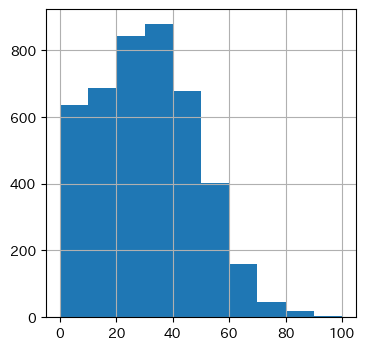

In [ ]:
euclid_distance_df["Distance"].hist(figsize=(4, 4))

### 「euclid_distance_df」に企業idを追加

In [ ]:
# Name1のcorporation_idを追加
euclid_distance_df = pd.merge(euclid_distance_df, employee_company_data, left_on='Name1', right_on='employee_id', how='left')
euclid_distance_df = euclid_distance_df.rename(columns={'corporation_id': 'Name1_corporation_id'})
euclid_distance_df = euclid_distance_df.drop('employee_id', axis=1)

# カラムの順序変更
new_column_order = ['Name1', 'Name1_corporation_id','Name2', 'Distance']
euclid_distance_df = euclid_distance_df[new_column_order]
euclid_distance_df.head(5)

,Name1,Name1_corporation_id,Name2,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,adopt_model,36.750541
1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,46.649142
2,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,0.000000
3,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,26.631179
4,008d1131-c9fc-4177-859c-dedc52575558,None,adopt_model,4.250511


### 「euclid_distance_df」に因子スコア（正規化済み）を追加
  - ユークリッド距離算出によるローデータが「euclid_distance_df」

In [ ]:
# Name1の因子のカラム名を作成
Name1_factor_dict = {}
for i in factor_type_english:
  Name1_factor_dict[i]="Name1_" + i

# Name2の因子のカラム名を作成
Name2_factor_dict = {}
for i in factor_type_english:
  Name2_factor_dict[i]="Name2_" + i

In [ ]:
# Name1の因子データを追加
cluster_df = pd.merge(euclid_distance_df, factor_score_scaling, left_on='Name1', right_on='employee_id', how='left')
cluster_df = cluster_df.rename(columns = Name1_factor_dict)
cluster_df = cluster_df.rename(columns = {"fullname":"Name1_fullname", "employee_id":"Name1_emoployee_id"})

# employee_idは削除
euclid_distance_df = cluster_df.drop(['Name1_emoployee_id'], axis=1)
euclid_distance_df.head(5)

,Name1,Name1_corporation_id,Name2,Distance,Name1_resilience,Name1_activity,Name1_achievement,Name1_fullname
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,adopt_model,36.750541,55.327174,36.126980,39.569430,NaN
1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,46.649142,34.790523,37.748006,34.778784,中野上 龍太郎
2,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,0.000000,83.001930,90.500002,83.227109,相月 俊紀
3,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,26.631179,61.138334,54.459899,38.825621,ルパワッタゲ アナン
4,008d1131-c9fc-4177-859c-dedc52575558,None,adopt_model,4.250511,61.224437,73.157171,69.123035,黒澤 愛夏


In [ ]:
euclid_distance_df

,Name1,Name1_corporation_id,Name2,Distance,Name1_resilience,Name1_activity,Name1_achievement,Name1_fullname
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,adopt_model,36.750541,55.327174,36.126980,39.569430,NaN
1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,46.649142,34.790523,37.748006,34.778784,中野上 龍太郎
2,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,0.000000,83.001930,90.500002,83.227109,相月 俊紀
3,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,26.631179,61.138334,54.459899,38.825621,ルパワッタゲ アナン
4,008d1131-c9fc-4177-859c-dedc52575558,None,adopt_model,4.250511,61.224437,73.157171,69.123035,黒澤 愛夏
...,...,...,...,...,...,...,...,...
4342,fff22958-1634-4517-b656-40b8095bc8bd,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,32.580940,38.323037,51.323385,47.064602,椛沢 はるな
4343,fff7ab5e-fe53-4704-9b9a-34b3e371ad47,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,17.758449,68.470392,46.047910,67.936091,小泉 拓巳
4344,ffff3122-60fd-4795-9f85-0b20d0640222,76230de6-c0ec-42a6-a6c9-9c855f49419f,adopt_model,36.783306,27.396197,57.305418,54.080538,NaN
4345,G00019,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,0.000000,81.000000,87.000000,80.000000,田川 勇輝


In [ ]:
euclid_distance_df[euclid_distance_df["Distance"]==0]

,Name1,Name1_corporation_id,Name2,Distance,Name1_resilience,Name1_activity,Name1_achievement,Name1_fullname
2,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,0.0,83.001930,90.500002,83.227109,相月 俊紀
23,01747050-717f-444a-b1e9-61d5663ca15b,8c5d42ef-714e-459e-94e5-278dc9f05ba4,adopt_model,0.0,77.861865,75.861676,67.225088,NaN
60,03ebc8a6-6f76-4e36-b287-8017df32177c,484af9fd-35ed-4e25-8735-a8ebcff157d7,adopt_model,0.0,117.541483,132.046394,88.258020,NaN
128,076e0244-c265-4ee2-a8b3-6288e7adef14,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,0.0,76.947569,75.894285,66.642036,𠮷田 篤史
170,09faaa7a-e38b-418c-a886-5dcdfb3a0f8a,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,0.0,69.277353,69.410631,66.828299,平田 瑠那
...,...,...,...,...,...,...,...,...
4260,faee4952-adfd-4829-8d01-1c7edac6a3c7,56f195ed-73e8-4efe-bdd5-4b26072e6080,adopt_model,0.0,90.415699,90.905001,69.607087,牧野 航大
4315,fe574417-c0bc-4814-bc29-c6dcdb70fee7,76230de6-c0ec-42a6-a6c9-9c855f49419f,adopt_model,0.0,72.751922,67.864305,78.832658,NaN
4316,fe7224d3-345e-4d64-a740-bbdb952eda54,76230de6-c0ec-42a6-a6c9-9c855f49419f,adopt_model,0.0,74.837595,81.119884,71.322787,NaN
4330,ff43c227-1be4-4dd4-8099-88b340d826dd,76230de6-c0ec-42a6-a6c9-9c855f49419f,adopt_model,0.0,94.036654,100.000000,94.427946,NaN


In [ ]:
# 各因子の不等式をカラムとして取得
for key, value in adopt_model_raw.items():
    condition_tuple = value[0]
    condition_lambda, th1, th2, cate = condition_tuple
    euclid_distance_df[key + '_th1'] = th1
    euclid_distance_df[key + '_th2'] = th2
    euclid_distance_df[key + '_cate'] = cate
euclid_distance_df.head(3)

## HRTメンバに絞る

In [ ]:
hrt_member = [
"河村 彰哉",
"杼木 悠人",
"小奈 百花",
"森脇 斗也",
"白井 陽平",
"福井 凪桜",
"佐藤 暖流",
"大滝 圭修",
"齋藤 匠",
"石田 貴義",
"德永 眞哉",
"塚本 貴之",
"川口 耀平",
"関口 一騎",
"下畑剣 一郎",
"稲村 麟",
"香川 淳",
"三口 廉",
"松本 悠太郎",
"岡本 侑樹",
"縄巻 一鴻",
"桐生 直輝",
"山下 翔",
"佐々木 美奈",
"三浦 一希",
"山本 寛太",
"岡島 喜希",
"牧野 航大",
"岩本 健太郎",
"𠮷田 球花",
"矢野 貴大",
"瀬上 真宏"
]

In [ ]:
# Name1がHRTメンバーに絞る
euclid_distance_hrt = euclid_distance_df[euclid_distance_df['Name1_fullname'].isin(hrt_member)].reset_index(drop=True)
euclid_distance_hrt.head(3)

In [ ]:
# fullnameがHRTメンバーに絞る
input_data_hrt = input_data[input_data['fullname'].isin(hrt_member)].reset_index(drop=True)
input_data_hrt.head(3)

In [ ]:
euclid_distance_hrt.to_csv("euclid_distance_hrt.csv", index=False)

## ユークリッド距離_アウトプット

In [ ]:
# 二名の「名前」を入力すると、採用モデルとのマッチング度合いを表示
# 【テスト】Name1：0013d97e-ea35-492e-b2e3-ba9f0badc5cf
# 【テスト】corporation_id：89eac118-a1ce-45a2-847c-c78c435193ac
name = input("相性を見たい「employee_id」を書いてください⇒")
corporation_id = input("その方々の「corporation_id」を書いてください⇒")

print("-----------------------")
compatibility_filtering = euclid_distance_df[
    (euclid_distance_df["Name1"] == name) &  # name が Nameに存在
    (euclid_distance_df["Name1_corporation_id"] == corporation_id)] # Name1_corporation_id が corporation_id と一致

compatibility_filtering_score = compatibility_filtering["Distance"].values[0]
print(f"その方と採用モデルのマッチング度合いは{round(100-compatibility_filtering_score,2)}点/100点です。" ) #「100-距離」で算出

# マハラノビス距離

## マハラノビス距離_実装

In [ ]:
np.array(adopt_model_upper)

array([0.66, 0.5 , 0.7 , 0.76, 0.8 ])

In [ ]:
# ユークリッド距離を算出
names = input_data_revision["employee_id"].unique()
euclid_distance = []

for i in range(len(names)):
  print1 = input_data_revision[input_data_revision['employee_id'] == names[i]].values[0][1:6]
  if input_data_revision[input_data_revision['employee_id'] == names[i]]['inequality_flag'].values[0] == 1:
    print2 = np.array(adopt_model_upper)
  else:
    print2 = np.array(adopt_model_upper_outside)
  distance = np.linalg.norm(print1 - print2) #ユークリッド距離
  euclid_distance.append([names[i], "adopt_model", distance])

# データフレーム化
euclid_distance_df = pd.DataFrame(euclid_distance, columns=['Name1', 'Name2', 'Distance'])

# ユークリッド距離を正規化
scaler = MinMaxScaler()
euclid_distance_df['Distance'] = scaler.fit_transform(euclid_distance_df[['Distance']])*100

# 距離の値を小数点第2位で四捨五入
euclid_distance_df["Distance"] = round(euclid_distance_df["Distance"],2)

euclid_distance_df.head(3)

In [ ]:
input_data.iloc[1, 1:]

,1
achievement,51.964035
activity,42.270162
competitiveness,44.312664
prudence,28.304957
purposeful,20.538403
fullname,NaN


In [ ]:
# マハラノビス距離を算出
cov = input_data.iloc[:, 1:].cov() # 共分散行列
inv_cov = np.linalg.inv(cov)  # 共分散行列の逆行列

names = input_data["employee_id"].unique()
mahalanobis_distance = []

for i in range(len(names)):
  print1 = input_data_revision[input_data_revision['employee_id'] == names[i]].values[0][1:6]
  if input_data_revision[input_data_revision['employee_id'] == names[i]]['inequality_flag'].values[0] == 1:
    print2 = np.array(adopt_model_upper)
  else:
    print2 = np.array(adopt_model_upper_outside)
  distance = mahalanobis(input_data.iloc[i, 1:], print2, inv_cov) #マハラノビス距離
  distance = np.linalg.norm(print1 - print2) #ユークリッド距離
  euclid_distance.append([names[i], "adopt_model", distance])

for i in range(len(names)):
    for j in range(i+1, len(names)):
        distance = mahalanobis(input_data.iloc[i, 1:], input_data.iloc[j, 1:], inv_cov) #マハラノビス距離
        mahalanobis_distance.append([names[i], names[j], distance])

# データフレーム化
mahalanobis_distance_df = pd.DataFrame(mahalanobis_distance, columns=['Name1', 'Name2', 'Distance'])

# 正規化
scaler = MinMaxScaler()
mahalanobis_distance_df['Distance'] = scaler.fit_transform(mahalanobis_distance_df[['Distance']])*100

# 距離の値を小数点第2位で四捨五入
mahalanobis_distance_df["Distance"] = round(mahalanobis_distance_df["Distance"],2)
mahalanobis_distance_df.head(3)

,Name1,Name2,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0033e100-e265-45cb-8c98-2f20d4d54184,34.05
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,004d1690-175d-484f-b35a-46326d8c2bcc,8.60
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,00857a9d-9622-4c65-983e-ae062d6e2b19,29.09


In [ ]:
# Name1のcorporation_idを追加
mahalanobis_distance_df = pd.merge(mahalanobis_distance_df, employee_company_data, left_on='Name1', right_on='employee_id', how='left')
mahalanobis_distance_df = mahalanobis_distance_df.rename(columns={'corporation_id': 'Name1_corporation_id'})
mahalanobis_distance_df = mahalanobis_distance_df.drop('employee_id', axis=1)

# Name2のcorporation_idを追加
mahalanobis_distance_df = pd.merge(mahalanobis_distance_df, employee_company_data, left_on='Name2', right_on='employee_id', how='left')
mahalanobis_distance_df = mahalanobis_distance_df.rename(columns={'corporation_id': 'Name2_corporation_id'})
mahalanobis_distance_df = mahalanobis_distance_df.drop('employee_id', axis=1)

# カラムの順序変更
new_column_order = ['Name1', 'Name1_corporation_id','Name2', 'Name2_corporation_id', 'Distance']
mahalanobis_distance_df = mahalanobis_distance_df[new_column_order]
mahalanobis_distance_df.head(3)

,Name1,Name1_corporation_id,Name2,Name2_corporation_id,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,34.05
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,8.60
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,29.09


## マハラノビス距離_クラスター分析

### エルボー法

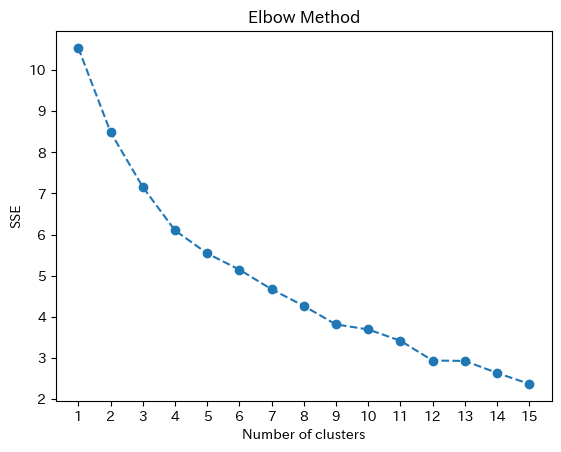

In [ ]:
#【def】エルボー法を実行
max_cluster_num = 15 #クラスター数
elbow_method(max_cluster_num= max_cluster_num)

### 非階層型クラスター分析

In [ ]:
#マハラノビス距離_クラスター分析
def kmeans_mahalanobis(n_clusters, max_iter=100, random_state=None):
    X = input_data.drop('employee_id', axis=1)

    np.random.seed(random_state)
    cov = np.cov(X, rowvar=False) # 共分散行列
    inv_cov_mahalanobis = np.linalg.inv(cov) # 共分散行列の逆行列

    # 初期のクラスタ中心点をクラスター数分作成
    centers = X.sample(n=n_clusters).to_numpy()

    for _ in range(max_iter):
        # 各点のクラスタ割り当て
        labels = []
        for _, row in X.iterrows(): #_：使用しない、row：カラムと値
          if 'cluster' in row.index:
            distances = [mahalanobis(row.drop('cluster'), center, inv_cov) for center in centers] #各中心点とデータ点のマハラノビス距離
          else:
            distances = [mahalanobis(row, center, inv_cov) for center in centers] #各中心点とデータ点のマハラノビス距離
          labels.append(np.argmin(distances))  # 最も近いマハラノビス距離のインデックスを取得
        X['cluster'] = labels

        # クラスタごとに新しい中心点を計算
        new_centers = X.groupby('cluster').mean().to_numpy()

        # 中心点が収束している場合、終了
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

    # クラスター番号を付与
    factor_score_scaling = input_data
    factor_score_scaling["cluster"] = labels

    return factor_score_scaling

In [ ]:
# def文を実行
n_clusters_mahalanobis = 4  #クラスター数
kmeans_mahalanobis(n_clusters=n_clusters_mahalanobis, random_state=42).head(5)

,employee_id,achievement,activity,competitiveness,prudence,purposeful,cluster
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0.327134,0.192838,0.383012,0.616003,0.674641,1
1,0033e100-e265-45cb-8c98-2f20d4d54184,0.582824,0.574648,0.327768,0.728115,0.897098,0
2,004d1690-175d-484f-b35a-46326d8c2bcc,0.491663,0.259112,0.476509,0.501228,0.582356,2
3,00857a9d-9622-4c65-983e-ae062d6e2b19,0.566319,0.280805,0.473780,0.234083,0.459396,2
4,008d1131-c9fc-4177-859c-dedc52575558,0.320771,0.353634,0.463381,0.963481,1.000000,0


In [ ]:
# Name1の因子データを追加
cluster_df = pd.merge(mahalanobis_distance_df, factor_score_scaling, left_on='Name1', right_on='employee_id', how='left')
cluster_df = cluster_df.rename(columns={'achievement': 'Name1_achievement', 'activity': 'Name1_activity',
                                          'competitiveness':'Name1_competitiveness', 'prudence':'Name1_prudence','purposeful':'Name1_purposeful', 'cluster':'Name1_cluster'})

# Name2の因子データを追加
cluster_df = pd.merge(cluster_df, factor_score_scaling, left_on='Name2', right_on='employee_id', how='left')
cluster_df = cluster_df.drop(['employee_id_x','employee_id_y','cluster'], axis=1)
mahalanobis_distance_df = cluster_df.rename(columns={'achievement': 'Name2_achievement', 'activity': 'Name2_activity',
                                          'competitiveness':'Name2_competitiveness', 'prudence':'Name2_prudence','purposeful':'Name2_purposeful'})

# カラムの順序変更
new_column_order = ['Name1', 'Name1_corporation_id','Name1_achievement','Name1_activity','Name1_competitiveness','Name1_prudence','Name1_purposeful','Name1_cluster',
                    'Name2', 'Name2_corporation_id','Name2_achievement','Name2_activity','Name2_competitiveness','Name2_prudence','Name2_purposeful', 'Distance']
mahalanobis_distance_df = mahalanobis_distance_df[new_column_order]
mahalanobis_distance_df.head(5)

,Name1,Name1_corporation_id,Name1_achievement,Name1_activity,Name1_competitiveness,Name1_prudence,Name1_purposeful,Name1_cluster,Name2,Name2_corporation_id,Name2_achievement,Name2_activity,Name2_competitiveness,Name2_prudence,Name2_purposeful,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,0033e100-e265-45cb-8c98-2f20d4d54184,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.582824,0.574648,0.327768,0.728115,0.897098,34.05
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,004d1690-175d-484f-b35a-46326d8c2bcc,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.491663,0.259112,0.476509,0.501228,0.582356,8.60
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,00857a9d-9622-4c65-983e-ae062d6e2b19,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.566319,0.280805,0.473780,0.234083,0.459396,29.09
3,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,008d1131-c9fc-4177-859c-dedc52575558,None,0.320771,0.353634,0.463381,0.963481,1.000000,29.21
4,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,89eac118-a1ce-45a2-847c-c78c435193ac,0.327134,0.192838,0.383012,0.616003,0.674641,1,00c87eaa-b4ff-4862-8172-d788d26b7b5d,56f195ed-73e8-4efe-bdd5-4b26072e6080,0.342053,0.273011,0.570171,0.634338,0.615522,8.33


### クラスター結果を可視化

In [ ]:
#【def】クラスター結果の可視化を実行
# マラノビス距離：mahalanobis_distance_df
mds(mahalanobis_distance_df)

## マハラノビス距離_アウトプット

In [ ]:
# 「名前」を入力すると、類似した人が表示される。
# 【テスト】Name1：0013d97e-ea35-492e-b2e3-ba9f0badc5cf
# 【テスト】corporation_id：89eac118-a1ce-45a2-847c-c78c435193ac
name = input("相性を見たい「employee_id」を書いてください⇒")
corporation_id = input("その方の「corporation_id」を書いてください⇒")

print("その方と相性が良い方は以下になります。" )
compatibility_filtering = mahalanobis_distance_df[(mahalanobis_distance_df["Name1"] == name)
                                      | (mahalanobis_distance_df["Name2"] == name)
                                      & (mahalanobis_distance_df["Name1_corporation_id"] == corporation_id)
                                      & (mahalanobis_distance_df["Name2_corporation_id"] == corporation_id)]

compatibility_filtering_sort = compatibility_filtering[["Name1", "Name2", "Distance"]].sort_values(by="Distance").head(20).reset_index(drop=True)
display(compatibility_filtering_sort)

相性を見たい「employee_id」を書いてください⇒0013d97e-ea35-492e-b2e3-ba9f0badc5cf
その方の「corporation_id」を書いてください⇒89eac118-a1ce-45a2-847c-c78c435193ac
その方と相性が良い方は以下になります。


,Name1,Name2,Distance
0,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,00c87eaa-b4ff-4862-8172-d788d26b7b5d,8.33
1,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,004d1690-175d-484f-b35a-46326d8c2bcc,8.60
2,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,015ddec2-7e2a-4d53-b320-6329d14f92d9,12.62
3,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,028b344b-4319-4fcf-ba4d-8e1ba54900f6,16.07
4,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,020fbe87-ae25-415f-b8d0-5207735d9ce7,19.36
5,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,022380d3-c46a-4bf1-a1c1-6d327bb3fda8,20.96
6,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,02e7a636-5d12-47d8-8a06-398ca38f9f8a,26.30
7,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,014e447c-1b3e-41a4-8ac5-8d50c10bfeb1,26.91
8,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0283de03-ebf4-48c4-bf21-61b1f9dcaf40,27.99
9,0013d97e-ea35-492e-b2e3-ba9f0badc5cf,0236b65a-efa7-4903-b931-957395428de5,28.96


In [ ]:
# 二名の「名前」を入力すると、マッチング度合いが表示される。
# 【テスト】Name1：02fc1d8c-0f4c-4772-b863-99b2afa72243
# 【テスト】Name2：031a3093-4418-4b3c-9a1a-011f0930c5d3
# 【テスト】corporation_id：56f195ed-73e8-4efe-bdd5-4b26072e6080
name1 = input("相性を見たい「employee_id」を書いてください⇒")
name2 = input("相性を見たい「employee_id」を書いてください⇒")
corporation_id = input("その方々の「corporation_id」を書いてください⇒")

print("-----------------------")
compatibility_filtering = mahalanobis_distance_df[
    ((mahalanobis_distance_df["Name1"] == name1) | (mahalanobis_distance_df["Name2"] == name1)) &  # name1 が Name1 または Name2 に存在する
    ((mahalanobis_distance_df["Name1"] == name2) | (mahalanobis_distance_df["Name2"] == name2)) &  # name2 が Name1 または Name2 に存在する
    (mahalanobis_distance_df["Name1_corporation_id"] == corporation_id) &  # Name1_corporation_id が corporation_id と一致する
    (mahalanobis_distance_df["Name2_corporation_id"] == corporation_id)    # Name2_corporation_id が corporation_id と一致する
    ]

compatibility_filtering_score = compatibility_filtering["Distance"].values[0]
print(f"その方々のマッチング度合いは{round(100-compatibility_filtering_score,2)}点/100点です。" ) #「100-距離」で算出

相性を見たい「employee_id」を書いてください⇒02fc1d8c-0f4c-4772-b863-99b2afa72243
相性を見たい「employee_id」を書いてください⇒031a3093-4418-4b3c-9a1a-011f0930c5d3
その方々の「corporation_id」を書いてください⇒56f195ed-73e8-4efe-bdd5-4b26072e6080
-----------------------
その方々のマッチング度合いは3.29点/100点です。


## CSVダウンロード

In [ ]:
# #LowdataをUTF-8でCSVファイルに保存
# file_path_ex = "G:マイドライブ/content/drive/My Drive/mar-データ戦略/事業施策/HRTech/[HRT]適性マッチのマッチングロジック/factorTypeIdと因子名.csv"
# mahalanobis_distance_df.to_csv(file_path_ex, index=False, encoding='utf-8')